In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)

os.chdir('..')

%load_ext autoreload
%autoreload

In [2]:
import yaml
import itertools

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm
from scipy.stats import wasserstein_distance

from utils import datasets, tscp, metrics, mmd
from utils.ensembles import EnsembleCPDModel, DistanceEnsembleCPDModel
from utils.visualize import visualize_predictions

In [3]:
'''
def wasserstein_distance_batch(a, b):
    # a, b: (batch_size, window_size, num_models)
    
    batch_size, window_size, num_models = a.shape
    
    dist_batch = []
    
    for i in range(batch_size):
        sample_1 = a[i].flatten() # (window_size * num_models)
        sample_2 = b[i].flatten()
        
        curr_dist = wasserstein_distance(sample_1, sample_2)
        
        dist_batch.append(curr_dist)
        
    return torch.Tensor(dist_batch)
'''

In [4]:
'''
def anchor_window_detector_batch(
    ensemble_preds, window_size, distance="mmd", kernel="rbf", anchor_window_type="start", bandwidth_range=None
) -> torch.Tensor:
    #ensemble_preds - output of .predict_all_model(), shape is (n_models, batch_size, seq_len)
    
    assert distance in ["mmd", "cosine", "wasserstein"], "Unknown distance type"
    assert anchor_window_type in ["start", "prev", "combined"], "Unknown window type"
    
    _, batch_size, seq_len = ensemble_preds.shape
    
    #print("n_models:", _)
    #print("batch_size:", batch_size)
    #print("seq_len:", seq_len)

    future_idx_range = torch.arange(seq_len)[window_size:]

    # first window_size elements are zeros
    dist_scores_batch = torch.zeros((batch_size, seq_len))
    
    #print("dist_scores_batch:", dist_scores_batch.shape)
    
    for future_idx in future_idx_range:
        if anchor_window_type == "start":
            anchor_wnd = ensemble_preds[:, :, :window_size]
        elif anchor_window_type == "prev":
            
            anchor_window_start = max(0, future_idx - 2 * window_size)
            anchor_window_end = anchor_window_start + window_size 
             
            anchor_wnd = ensemble_preds[:, :, anchor_window_start : anchor_window_end]
        else:
            half_wnd_size = window_size // 2 
            anchor_wnd = torch.cat(
                (ensemble_preds[:, :, :half_wnd_size], ensemble_preds[:, :, future_idx - 2 * half_wnd_size : future_idx - half_wnd_size]),
                dim=-1
            )
            
            window_size = half_wnd_size * 2
            
        anchor_wnd = anchor_wnd.permute(1, 2, 0)
        future_wnd = ensemble_preds[:, :, future_idx - window_size : future_idx].permute(1, 2, 0) #.transpose(0, 1).reshape(batch_size, -1, 1)
        
        # print("anchor_wnd:", anchor_wnd.shape)
        # print("future_wnd:", future_wnd.shape)
 
        #dist_batch = torch.zeros(batch_size)
        
        # compute mean pairwise distance
        #for i in range(window_size): # TODO: fix iteration
        #    anchor = anchor_wnd[:, :, i].transpose(0, 1).reshape(batch_size, -1, 1)
        #    
        #    if distance == "mmd":
        #        dist_batch += mmd.MMD_batch(anchor, future, kernel=kernel, bandwidth_range=bandwidth_range)
        #    else:
        #        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        #        curr_dist = cos(anchor.squeeze(), future.squeeze())
        #        curr_dist = 1.0 - torch.where(curr_dist >= 0, curr_dist, torch.zeros_like(curr_dist))
        #        dist_batch += curr_dist
        
        #dist_batch /= anchor_wnd.shape[-1]
        
        if distance == "mmd":
            dist_batch = mmd.MMD_batch(anchor_wnd, future_wnd, kernel=kernel, bandwidth_range=bandwidth_range)
        elif distance == "wasserstein":
            dist_batch = wasserstein_distance_batch(anchor_wnd, future_wnd)
        else:
            raise NotImplementedError("Only MMD distance is currently implemented")
        
        #print("dist_batch:", dist_batch.shape)
        
        #print("dist_scores_batch[:, future_idx]:", dist_scores_batch[:, future_idx].shape)
            
        dist_scores_batch[:, future_idx] = dist_batch

    return dist_scores_batch
'''

# New MMD procedure

In [3]:
ens_preds_batch = torch.rand(10, 64, 20)

mmd_scores_batch = mmd.anchor_window_detector_batch(
    ens_preds_batch, window_size=2, distance="wasserstein", anchor_window_type="combined"
)
#cosine_scores_batch = anchor_window_detector_batch(
#    ens_preds_batch, window_size=2, distance="cosine", anchor_window_type="start"
#)

mmd_scores_batch.shape #, cosine_scores_batch.shape

torch.Size([64, 20])

# TS-CP for HAR

In [4]:
model_type = "tscp"

experiments_name = "human_activity"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, 'r') as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type
args_config["num_workers"] = 4

args_config["learning"]["accelerator"] = 'cpu'
args_config["learning"]["devices"] = 1

train_dataset, test_dataset = datasets.CPDDatasets(experiments_name).get_dataset_()

train_dataloader = DataLoader(train_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_dataloader_shuffle = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [5]:
ens_har_tscp = EnsembleCPDModel(args_config, n_models=10)
ens_har_tscp.load_models_list(
    f"saved_models/{model_type}/{experiments_name}/window_{args_config['model']['window']}"
)

In [6]:
batch, labels = next(iter(test_dataloader_shuffle))

ens_preds = ens_har_tscp.predict_all_models(batch)
ens_preds.shape

torch.Size([10, 32, 20])

In [7]:
mmd_scores_start = mmd.anchor_window_detector_batch(
    ens_preds, window_size=2, distance="mmd", anchor_window_type="start"
)

mmd_scores_prev = mmd.anchor_window_detector_batch(
    ens_preds, window_size=2, distance="mmd", anchor_window_type="prev"
)
mmd_scores_combined = mmd.anchor_window_detector_batch(
    ens_preds, window_size=2, distance="mmd", anchor_window_type="combined"
)

wass_scores_start = mmd.anchor_window_detector_batch(
    ens_preds, window_size=2, distance="wasserstein", anchor_window_type="start"
)

wass_scores_prev = mmd.anchor_window_detector_batch(
    ens_preds, window_size=2, distance="wasserstein", anchor_window_type="prev"
)
wass_scores_combined = mmd.anchor_window_detector_batch(
    ens_preds, window_size=2, distance="wasserstein", anchor_window_type="combined"
)

'''
cosine_scores_start = anchor_window_detector_batch(
    ens_preds, window_size=5, distance="cosine", anchor_window_type="start"
)
cosine_scores_prev = anchor_window_detector_batch(
    ens_preds, window_size=5, distance="cosine", anchor_window_type="prev"
)
cosine_scores_combined = anchor_window_detector_batch(
    ens_preds, window_size=5, distance="cosine", anchor_window_type="combined"
)
'''

cosine_scores_start = torch.zeros_like(mmd_scores_start)
cosine_scores_prev = torch.zeros_like(mmd_scores_start)
cosine_scores_combined = torch.zeros_like(mmd_scores_start)

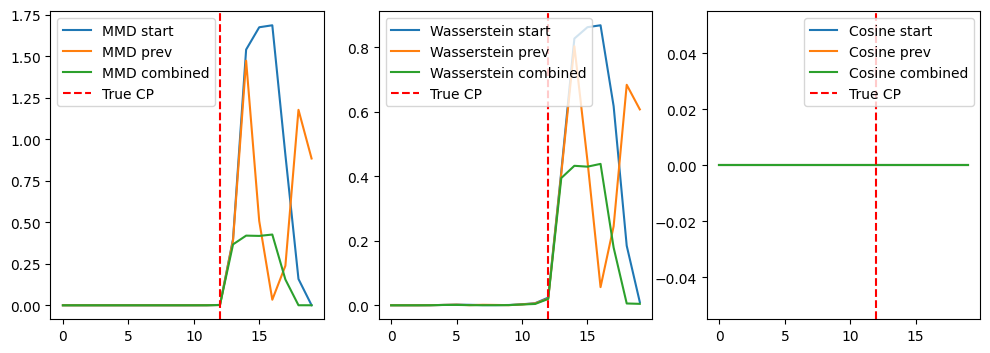

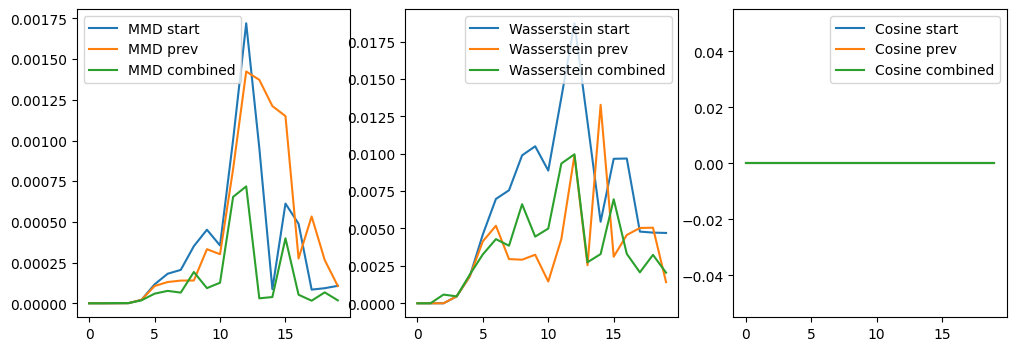

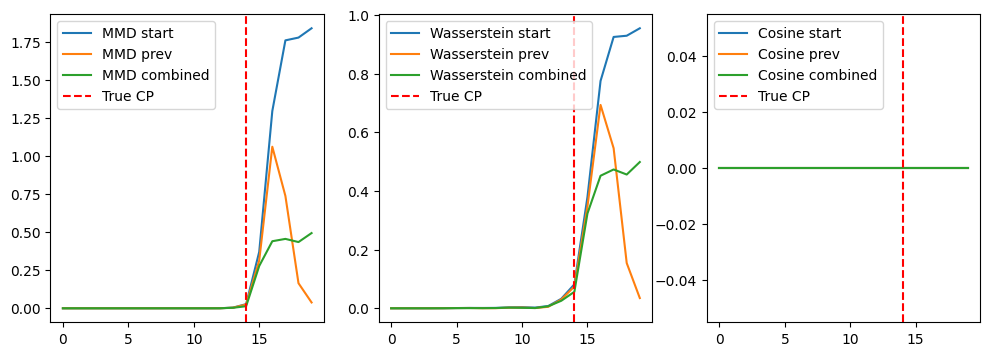

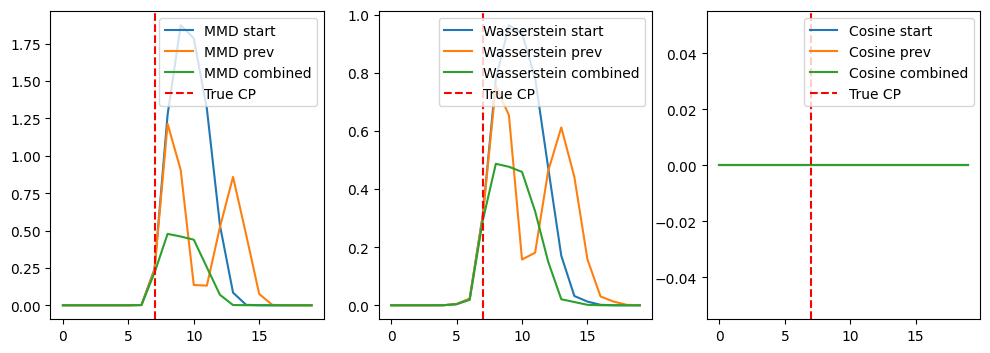

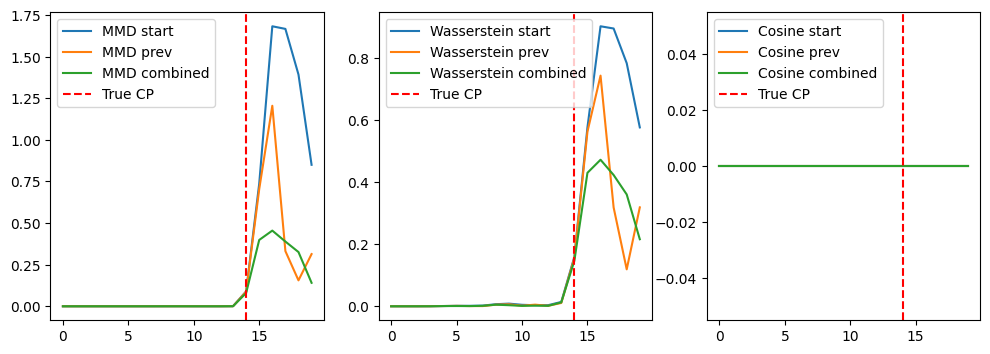

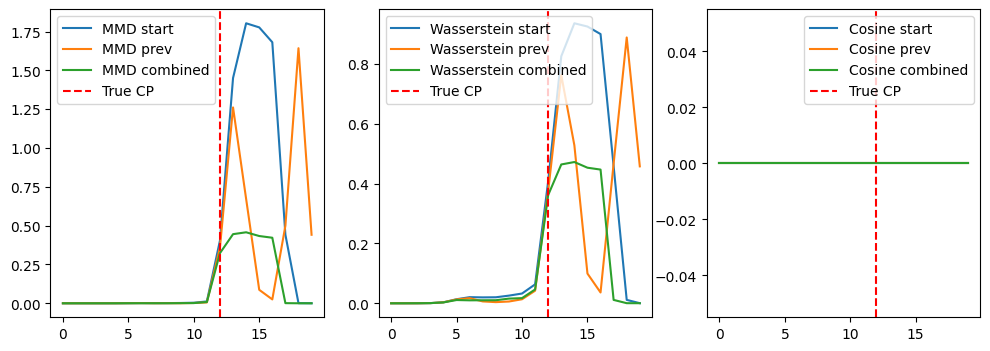

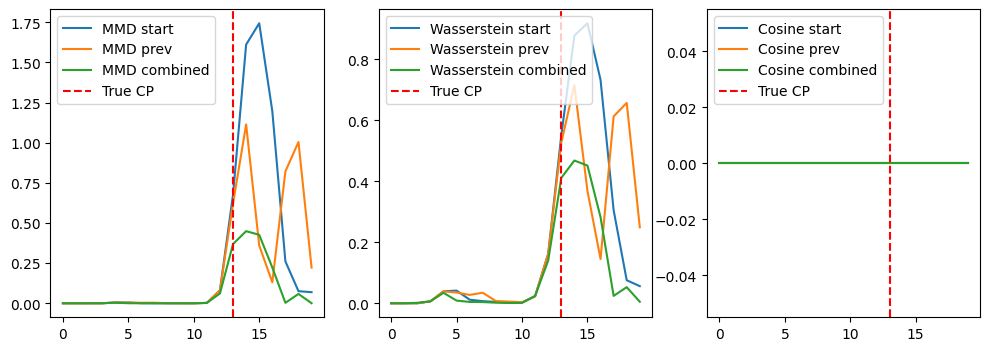

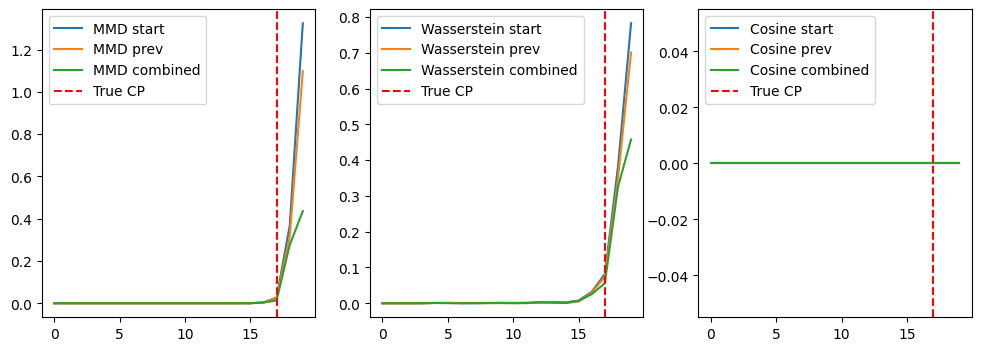

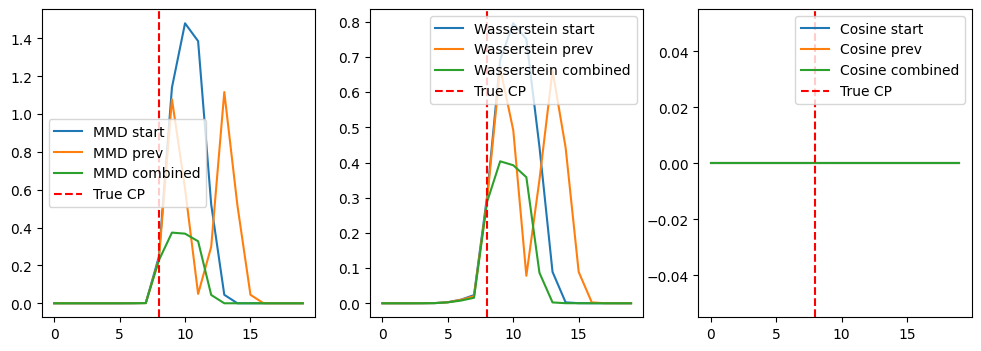

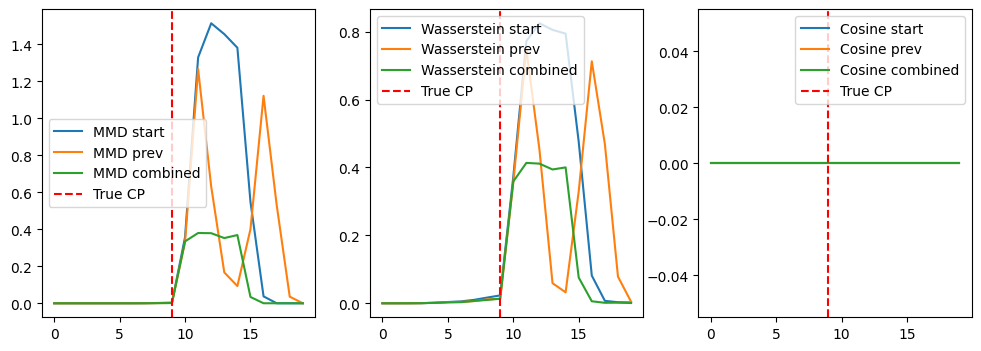

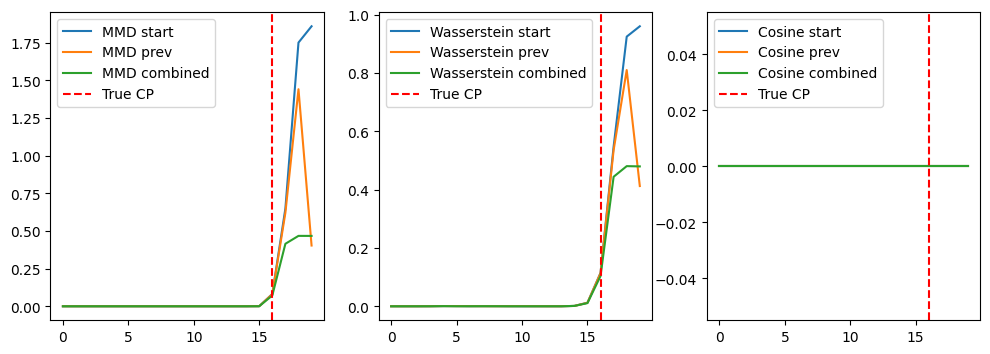

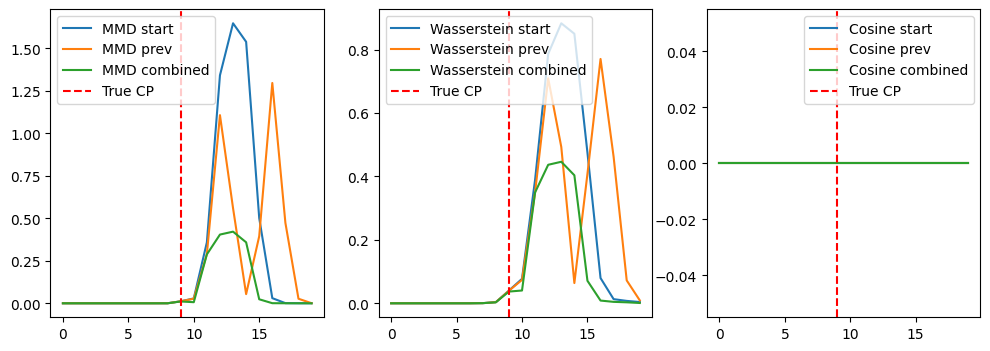

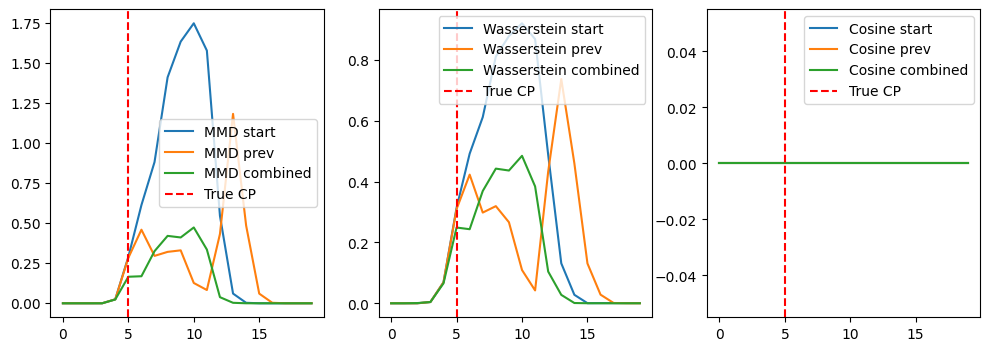

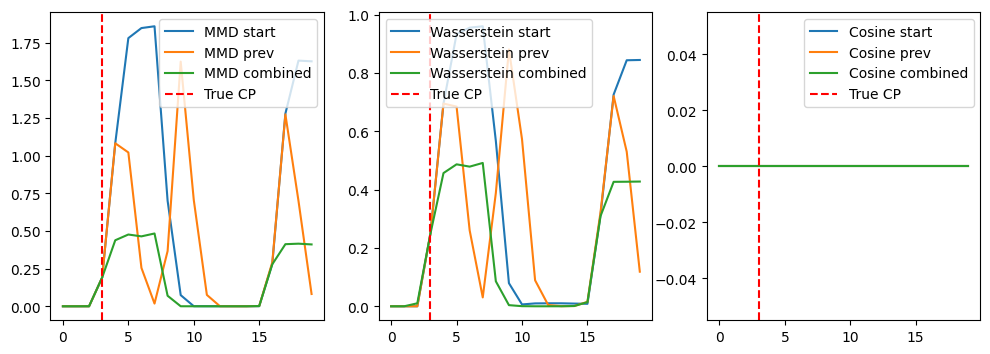

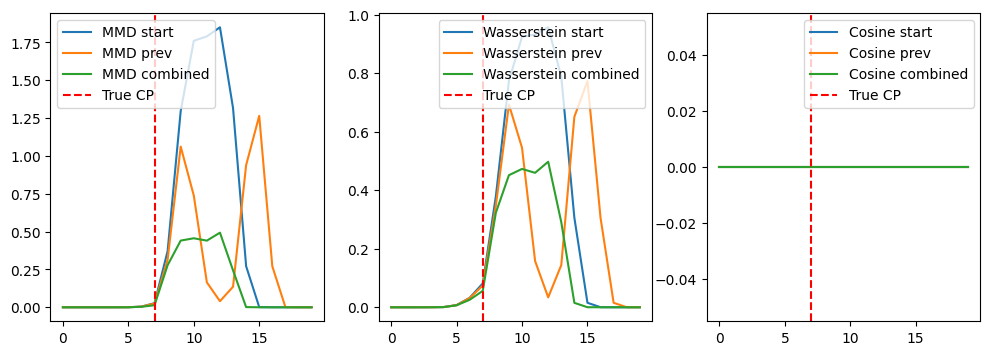

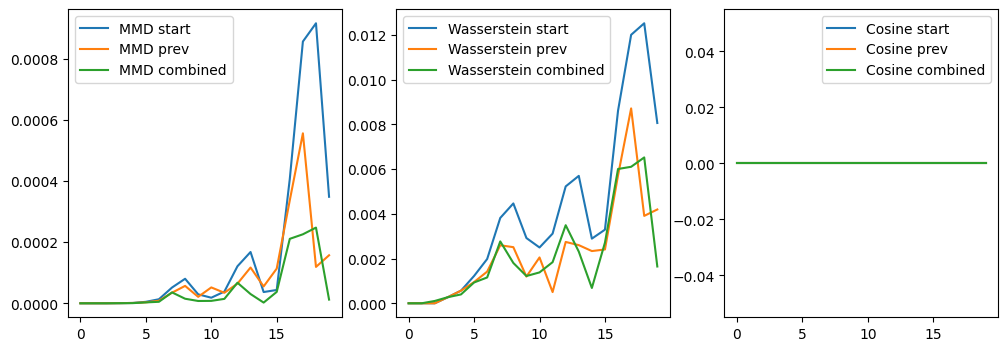

In [8]:
for idx in range(16):
    cp = labels[idx].argmax()
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    
    axs[0].plot(mmd_scores_start[idx], label="MMD start")
    axs[0].plot(mmd_scores_prev[idx], label="MMD prev")
    axs[0].plot(mmd_scores_combined[idx], label="MMD combined")
    if cp > 0:
        axs[0].axvline(cp, linestyle="--", c="red", label="True CP")
        
    axs[1].plot(wass_scores_start[idx], label="Wasserstein start")
    axs[1].plot(wass_scores_prev[idx], label="Wasserstein prev")
    axs[1].plot(wass_scores_combined[idx], label="Wasserstein combined")
    if cp > 0:
        axs[1].axvline(cp, linestyle="--", c="red", label="True CP")
    
    axs[2].plot(cosine_scores_start[idx], label="Cosine start")
    axs[2].plot(cosine_scores_prev[idx], label="Cosine prev")
    axs[2].plot(cosine_scores_combined[idx], label="Cosine combined")
    if cp > 0:
        axs[2].axvline(cp, linestyle="--", c="red", label="True CP")
    
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

## Compute metrics

In [6]:
test_out_bank, test_uncertainties_bank, test_labels_bank = metrics.collect_model_predictions_on_set(
    model=ens_har_tscp,
    test_loader=test_dataloader,
    model_type="ensemble_all_models",
    device="cpu",
    scale=args_config["predictions"]["scale"],
    step=args_config["predictions"]["step"],
    alpha=args_config["predictions"]["alpha"],
)

Collectting model's outputs


In [20]:
len(test_out_bank), test_out_bank[0].shape, test_out_bank[-1].shape 

(42, torch.Size([10, 32, 20]), torch.Size([10, 25, 20]))

In [21]:
from torch.utils.data import Dataset

class AllModelsOutputDataset(Dataset):
    """Fake dataset to store pre-computed all models' outputs for MMD model evaluation."""

    def __init__(self, test_out_bank, test_labels_bank):
        super().__init__()

        self.test_out = list(
            torch.cat(test_out_bank[:-1], dim=1).transpose(0, 1)
        )  # drop last batch
        # every prediction is (n_models, batch_size, seq_len)
        self.test_labels = list(torch.vstack(test_labels_bank[:-1]))
        #self.test_uncertainties = [None for _ in self.test_labels] 

    def __len__(self):
        return len(self.test_labels)

    def __getitem__(self, idx):
        return self.test_out[idx], self.test_labels[idx]

'''
class AllModelsOutputDataset(Dataset):
    """Fake dataset to store pre-computed all models' outputs for MMD model evaluation."""

    def __init__(self, test_out, test_labels):
        super().__init__()

        self.test_out = test_out[:-1]
        self.test_labels = test_labels[:-1]

    def __len__(self):
        return len(self.test_labels)

    def __getitem__(self, idx):
        return self.test_out[idx], self.test_labels[idx]
'''

'\n\nclass AllModelsOutputDataset(Dataset):\n    """Fake dataset to store pre-computed all models\' outputs for MMD model evaluation."""\n\n    def __init__(self, test_out, test_labels):\n        super().__init__()\n\n        self.test_out = test_out[:-1]\n        self.test_labels = test_labels[:-1]\n\n    def __len__(self):\n        return len(self.test_labels)\n\n    def __getitem__(self, idx):\n        return self.test_out[idx], self.test_labels[idx]\n'

In [22]:
all_preds_dataset = AllModelsOutputDataset(test_out_bank, test_labels_bank)
all_preds_dataloader = DataLoader(all_preds_dataset, batch_size=64)

In [23]:
batch, labels = next(iter(all_preds_dataloader))

batch.shape

torch.Size([64, 10, 20])

In [26]:
res_dict = {}

window_size_list = [1, 2, 3]
#anchor_window_type_list = ["start", "prev", "combined"]
anchor_window_type_list = ["start"]

threshold_list = np.linspace(0, 1, 10)

for window_size, anchor_window_type in itertools.product(window_size_list, anchor_window_type_list):
    print(f"window_size = {window_size}, anchor_window_type = {anchor_window_type}")
    res, best_th = metrics.evaluate_distance_ensemble_model(
        threshold_list=threshold_list,
        output_dataloader=all_preds_dataloader,
        margin_list=[1, 2, 4, 8],
        args_config=args_config,
        n_models=10,
        window_size=window_size,
        #kernel="rbf",
        anchor_window_type=anchor_window_type,
        distance="wasserstein",
        save_path=f"saved_models/{model_type}/{experiments_name}/window_{args_config['model']['window']}",
        device="cpu",
        verbose=True,
    )
    
    res_dict[(window_size, anchor_window_type)] = res[best_th]

  0%|          | 0/10 [00:00<?, ?it/s]

window_size = 1, anchor_window_type = start


  0%|          | 0/10 [00:00<?, ?it/s]

Results for best threshold = 0.3333333333333333
AUDC: 0.0, Time to FA: 10.1852, DD: 0.9024, F1: 0.9429, Cover: 0.8896, Max Cover: 0.8896
Max F1 with margin 1: 0.806
Max F1 with margin 2: 0.9222
Max F1 with margin 4: 0.9414
Max F1 with margin 8: 0.9439
window_size = 2, anchor_window_type = start


  0%|          | 0/10 [00:00<?, ?it/s]

Results for best threshold = 0.2222222222222222
AUDC: 0.0, Time to FA: 10.1814, DD: 0.9184, F1: 0.9424, Cover: 0.8878, Max Cover: 0.8878
Max F1 with margin 1: 0.7998
Max F1 with margin 2: 0.9202
Max F1 with margin 4: 0.941
Max F1 with margin 8: 0.9434
window_size = 3, anchor_window_type = start


100%|██████████| 10/10 [00:41<00:00,  4.13s/it]

Results for best threshold = 0.2222222222222222
AUDC: 0.0, Time to FA: 10.2721, DD: 1.1151, F1: 0.94, Cover: 0.8726, Max Cover: 0.8726
Max F1 with margin 1: 0.7397
Max F1 with margin 2: 0.9085
Max F1 with margin 4: 0.9376
Max F1 with margin 8: 0.9429


In [29]:
res_dict = {}

window_size_list = [1, 2, 3]
#anchor_window_type_list = ["start", "prev", "combined"]
anchor_window_type_list = ["prev"]

threshold_list = np.linspace(0, 1, 10)

for window_size, anchor_window_type in itertools.product(window_size_list, anchor_window_type_list):
    print(f"window_size = {window_size}, anchor_window_type = {anchor_window_type}")
    res, best_th = metrics.evaluate_distance_ensemble_model(
        threshold_list=threshold_list,
        output_dataloader=all_preds_dataloader,
        margin_list=[1, 2, 4, 8],
        args_config=args_config,
        n_models=10,
        window_size=window_size,
        #kernel="rbf",
        anchor_window_type=anchor_window_type,
        distance="wasserstein",
        save_path=f"saved_models/{model_type}/{experiments_name}/window_{args_config['model']['window']}",
        device="cpu",
        verbose=True,
    )
    
    res_dict[(window_size, anchor_window_type)] = res[best_th]

  0%|          | 0/10 [00:00<?, ?it/s]

window_size = 1, anchor_window_type = prev


  0%|          | 0/10 [00:00<?, ?it/s]

Results for best threshold = 0.2222222222222222
AUDC: 0.0, Time to FA: 10.1349, DD: 0.827, F1: 0.9371, Cover: 0.8943, Max Cover: 0.8943
Max F1 with margin 1: 0.8278
Max F1 with margin 2: 0.9222
Max F1 with margin 4: 0.941
Max F1 with margin 8: 0.9424
window_size = 2, anchor_window_type = prev


  0%|          | 0/10 [00:00<?, ?it/s]

Results for best threshold = 0.2222222222222222
AUDC: 0.0, Time to FA: 10.186, DD: 0.9375, F1: 0.9414, Cover: 0.8861, Max Cover: 0.8861
Max F1 with margin 1: 0.796
Max F1 with margin 2: 0.9131
Max F1 with margin 4: 0.94
Max F1 with margin 8: 0.9424
window_size = 3, anchor_window_type = prev


100%|██████████| 10/10 [00:41<00:00,  4.17s/it]

Results for best threshold = 0.1111111111111111
AUDC: 0.0, Time to FA: 10.1334, DD: 0.8582, F1: 0.9411, Cover: 0.891, Max Cover: 0.891
Max F1 with margin 1: 0.8173
Max F1 with margin 2: 0.9138
Max F1 with margin 4: 0.9401
Max F1 with margin 8: 0.944


In [30]:
res_dict = {}

window_size_list = [1, 2, 3]
#anchor_window_type_list = ["start", "prev", "combined"]
anchor_window_type_list = ["combined"]

threshold_list = np.linspace(0, 1, 10)

for window_size, anchor_window_type in itertools.product(window_size_list, anchor_window_type_list):
    print(f"window_size = {window_size}, anchor_window_type = {anchor_window_type}")
    res, best_th = metrics.evaluate_distance_ensemble_model(
        threshold_list=threshold_list,
        output_dataloader=all_preds_dataloader,
        margin_list=[1, 2, 4, 8],
        args_config=args_config,
        n_models=10,
        window_size=window_size,
        #kernel="rbf",
        anchor_window_type=anchor_window_type,
        distance="wasserstein",
        save_path=f"saved_models/{model_type}/{experiments_name}/window_{args_config['model']['window']}",
        device="cpu",
        verbose=True,
    )
    
    res_dict[(window_size, anchor_window_type)] = res[best_th]

  0%|          | 0/10 [00:00<?, ?it/s]

window_size = 1, anchor_window_type = combined


  0%|          | 0/10 [00:01<?, ?it/s]


ValueError: Distribution can't be empty.

In [9]:
res_dict = {}

window_size_list = [1, 2, 3]
anchor_window_type_list = ["start", "prev", "combined"]

threshold_list = np.linspace(0, 0.3, 5)

for window_size, anchor_window_type in itertools.product(window_size_list, anchor_window_type_list):
    print(f"window_size = {window_size}, anchor_window_type = {anchor_window_type}")
    res, best_th = metrics.evaluate_distance_ensemble_model(
        threshold_list=threshold_list,
        output_dataloader=all_preds_dataloader,
        margin_list=[1, 2, 4, 8],
        args_config=args_config,
        n_models=10,
        window_size=2,
        kernel="rbf",
        anchor_window_type="start",
        distance="mmd",
        save_path=f"saved_models/{model_type}/{experiments_name}/window_{args_config['model']['window']}",
        device="cpu",
        verbose=True,
    )
    
    res_dict[(window_size, anchor_window_type)] = res[best_th]

window_size = 1, anchor_window_type = start


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.38s/it]


Results for best threshold = 0.15
AUDC: 0.0, Time to FA: 11.1387, DD: 1.4558, F1: 0.8808, Cover: 0.8902, Max Cover: 0.8902
Max F1 with margin 1: 0.7931
Max F1 with margin 2: 0.857
Max F1 with margin 4: 0.8947
Max F1 with margin 8: 0.8947
window_size = 1, anchor_window_type = prev


 20%|██████████████████                                                                        | 1/5 [00:03<00:15,  3.83s/it]

KeyboardInterrupt



# BCE (norm) for Road Accidents

In [32]:
model_type = "seq2seq"

experiments_name = "road_accidents"

path_to_config = "configs/" + "video" + "_" + model_type + ".yaml"

with open(path_to_config, 'r') as f:
    args_config = yaml.safe_load(f.read())
    
args_config['loss_type'] = "bce"

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type
args_config["num_workers"] = 4

args_config["learning"]["accelerator"] = 'cuda'
args_config["learning"]["devices"] = 1

train_dataset, test_dataset = datasets.CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False)
test_dataloader_shuffle = DataLoader(test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=True)

In [33]:
test_out = torch.load("saved_outputs/bce/road_accidents/ra_all_models_test_preds.pt")
test_labels = torch.load("saved_outputs/bce/road_accidents/ra_test_labels.pt")

test_out.shape, test_labels.shape

(torch.Size([315, 10, 16]), torch.Size([315, 16]))

In [35]:
class AllModelsOutputDataset(Dataset):
    """Fake dataset to store pre-computed all models' outputs for MMD model evaluation."""

    def __init__(self, test_out, test_labels):
        super().__init__()

        self.test_out = test_out[:-1]
        self.test_labels = test_labels[:-1]

    def __len__(self):
        return len(self.test_labels)

    def __getitem__(self, idx):
        return self.test_out[idx], self.test_labels[idx]

In [36]:
all_preds_dataset = AllModelsOutputDataset(test_out, test_labels)
all_preds_dataloader = DataLoader(all_preds_dataset, batch_size=64)

ensemble_preds_batch, labels_batch = next(iter(all_preds_dataloader))

ensemble_preds_batch.shape, labels_batch.shape

(torch.Size([64, 10, 16]), torch.Size([64, 16]))

In [37]:
mmd_scores = mmd.anchor_window_detector_batch(
    ensemble_preds_batch.transpose(0, 1),
    window_size=2,
    distance="wasserstein", 
    kernel="rbf", 
    anchor_window_type="start"
)

mmd_scores.min(), mmd_scores.max()

(tensor(0.), tensor(0.8478))

In [41]:
res_dict = {}

window_size_list = [1, 2, 3]
anchor_window_type_list = ["start"]

threshold_list = np.linspace(0, 1, 10)

for window_size, anchor_window_type in itertools.product(window_size_list, anchor_window_type_list):
    print(f"window_size = {window_size}, anchor_window_type = {anchor_window_type}")
    res, best_th = metrics.evaluate_distance_ensemble_model(
        threshold_list=threshold_list,
        output_dataloader=all_preds_dataloader,
        margin_list=[1, 2, 4, 8],
        args_config=args_config,
        n_models=10,
        window_size=window_size,
        #kernel="rbf",
        anchor_window_type=anchor_window_type,
        distance="wasserstein",
        save_path=f"saved_models/{args_config['loss_type']}/{experiments_name}/layer_norm",
        device="cpu",
        verbose=True,
    )
    
    res_dict[(window_size, anchor_window_type)] = res[best_th]

  0%|          | 0/10 [00:00<?, ?it/s]

window_size = 1, anchor_window_type = start


  0%|          | 0/10 [00:00<?, ?it/s]

Results for best threshold = 0.5555555555555556
AUDC: 0.0, Time to FA: 15.7166, DD: 0.1911, F1: 0.6667, Cover: 0.9831, Max Cover: 0.9831
Max F1 with margin 1: 0.3636
Max F1 with margin 2: 0.5
Max F1 with margin 4: 0.56
Max F1 with margin 8: 0.6667
window_size = 2, anchor_window_type = start


  0%|          | 0/10 [00:00<?, ?it/s]

Results for best threshold = 0.5555555555555556
AUDC: 0.0, Time to FA: 15.7197, DD: 0.207, F1: 0.6667, Cover: 0.9814, Max Cover: 0.9814
Max F1 with margin 1: 0.1053
Max F1 with margin 2: 0.5
Max F1 with margin 4: 0.56
Max F1 with margin 8: 0.6667
window_size = 3, anchor_window_type = start


100%|██████████| 10/10 [01:06<00:00,  6.66s/it]

Results for best threshold = 0.4444444444444444
AUDC: 0.0, Time to FA: 15.6019, DD: 0.1847, F1: 0.6875, Cover: 0.9786, Max Cover: 0.9786
Max F1 with margin 1: 0.0909
Max F1 with margin 2: 0.3846
Max F1 with margin 4: 0.6
Max F1 with margin 8: 0.6875


In [42]:
res_dict = {}

window_size_list = [1, 2, 3]
anchor_window_type_list = ["prev"]

threshold_list = np.linspace(0, 1, 10)

for window_size, anchor_window_type in itertools.product(window_size_list, anchor_window_type_list):
    print(f"window_size = {window_size}, anchor_window_type = {anchor_window_type}")
    res, best_th = metrics.evaluate_distance_ensemble_model(
        threshold_list=threshold_list,
        output_dataloader=all_preds_dataloader,
        margin_list=[1, 2, 4, 8],
        args_config=args_config,
        n_models=10,
        window_size=window_size,
        #kernel="rbf",
        anchor_window_type=anchor_window_type,
        distance="wasserstein",
        save_path=f"saved_models/{args_config['loss_type']}/{experiments_name}/layer_norm",
        device="cpu",
        verbose=True,
    )
    
    res_dict[(window_size, anchor_window_type)] = res[best_th]

  0%|          | 0/10 [00:00<?, ?it/s]

window_size = 1, anchor_window_type = prev


  0%|          | 0/10 [00:00<?, ?it/s]

Results for best threshold = 0.2222222222222222
AUDC: 0.0, Time to FA: 15.707, DD: 0.1624, F1: 0.5833, Cover: 0.9854, Max Cover: 0.9854
Max F1 with margin 1: 0.5217
Max F1 with margin 2: 0.5217
Max F1 with margin 4: 0.5833
Max F1 with margin 8: 0.64
window_size = 2, anchor_window_type = prev


  0%|          | 0/10 [00:00<?, ?it/s]

Results for best threshold = 0.3333333333333333
AUDC: 0.0, Time to FA: 15.7102, DD: 0.1688, F1: 0.6667, Cover: 0.9851, Max Cover: 0.9851
Max F1 with margin 1: 0.3158
Max F1 with margin 2: 0.5455
Max F1 with margin 4: 0.72
Max F1 with margin 8: 0.72
window_size = 3, anchor_window_type = prev


100%|██████████| 10/10 [01:07<00:00,  6.74s/it]

Results for best threshold = 0.3333333333333333
AUDC: 0.0, Time to FA: 15.6306, DD: 0.1592, F1: 0.6429, Cover: 0.9809, Max Cover: 0.9809
Max F1 with margin 1: 0.1
Max F1 with margin 2: 0.4167
Max F1 with margin 4: 0.5926
Max F1 with margin 8: 0.6897


In [11]:
res_dict = {}

window_size_list = [1, 2, 3]
anchor_window_type_list = ["start", "prev", "combined"]

threshold_list = np.linspace(0, 0.2, 200)

for window_size, anchor_window_type in itertools.product(window_size_list, anchor_window_type_list):
    print(f"window_size = {window_size}, anchor_window_type = {anchor_window_type}")
    res, best_th = metrics.evaluate_distance_ensemble_model(
        threshold_list=threshold_list,
        output_dataloader=all_preds_dataloader,
        margin_list=[1, 2, 4, 8],
        args_config=args_config,
        n_models=10,
        window_size=window_size,
        kernel="rbf",
        anchor_window_type=anchor_window_type,
        distance="mmd",
        save_path=f"temp_saved_models/{args_config['loss_type']}/{experiments_name}/layer_norm",
        device="cpu",
        verbose=True,
    )
    
    res_dict[(window_size, anchor_window_type)] = res[best_th]

window_size = 1, anchor_window_type = start


100%|█████████████████████████████████████████| 200/200 [12:21<00:00,  3.71s/it]


Results for best threshold = 0.07738693467336684
AUDC: 0.0, Time to FA: 15.6762, DD: 0.1651, F1: 0.7586, Cover: 0.9861, Max Cover: 0.9861
Max F1 with margin 1: 0.5
Max F1 with margin 2: 0.56
Max F1 with margin 4: 0.6667
Max F1 with margin 8: 0.7143
window_size = 1, anchor_window_type = prev


100%|█████████████████████████████████████████| 200/200 [12:25<00:00,  3.73s/it]


Results for best threshold = 0.009045226130653268
AUDC: 0.0, Time to FA: 15.5746, DD: 0.0889, F1: 0.5517, Cover: 0.9868, Max Cover: 0.9868
Max F1 with margin 1: 0.5517
Max F1 with margin 2: 0.6
Max F1 with margin 4: 0.6452
Max F1 with margin 8: 0.6875
window_size = 1, anchor_window_type = combined


100%|█████████████████████████████████████████| 200/200 [12:29<00:00,  3.75s/it]


Results for best threshold = 0.03919597989949749
AUDC: 0.0, Time to FA: 15.7111, DD: 0.1714, F1: 0.7407, Cover: 0.9861, Max Cover: 0.9861
Max F1 with margin 1: 0.5217
Max F1 with margin 2: 0.5217
Max F1 with margin 4: 0.6923
Max F1 with margin 8: 0.7407
window_size = 2, anchor_window_type = start


100%|█████████████████████████████████████████| 200/200 [12:34<00:00,  3.77s/it]


Results for best threshold = 0.08341708542713569
AUDC: 0.0, Time to FA: 15.7111, DD: 0.1905, F1: 0.7857, Cover: 0.9875, Max Cover: 0.9875
Max F1 with margin 1: 0.5217
Max F1 with margin 2: 0.5833
Max F1 with margin 4: 0.6923
Max F1 with margin 8: 0.6923
window_size = 2, anchor_window_type = prev


100%|█████████████████████████████████████████| 200/200 [12:50<00:00,  3.85s/it]


Results for best threshold = 0.017085427135678392
AUDC: 0.0, Time to FA: 15.619, DD: 0.0889, F1: 0.6429, Cover: 0.9886, Max Cover: 0.9886
Max F1 with margin 1: 0.5926
Max F1 with margin 2: 0.6429
Max F1 with margin 4: 0.6897
Max F1 with margin 8: 0.7333
window_size = 2, anchor_window_type = combined


100%|█████████████████████████████████████████| 200/200 [12:36<00:00,  3.78s/it]


Results for best threshold = 0.041206030150753775
AUDC: 0.0, Time to FA: 15.7048, DD: 0.1905, F1: 0.7586, Cover: 0.9871, Max Cover: 0.9871
Max F1 with margin 1: 0.5
Max F1 with margin 2: 0.56
Max F1 with margin 4: 0.6667
Max F1 with margin 8: 0.6667
window_size = 3, anchor_window_type = start


100%|█████████████████████████████████████████| 200/200 [12:56<00:00,  3.88s/it]


Results for best threshold = 0.08542713567839197
AUDC: 0.0, Time to FA: 15.7683, DD: 0.1937, F1: 0.7692, Cover: 0.9883, Max Cover: 0.9883
Max F1 with margin 1: 0.5455
Max F1 with margin 2: 0.6087
Max F1 with margin 4: 0.72
Max F1 with margin 8: 0.72
window_size = 3, anchor_window_type = prev


100%|█████████████████████████████████████████| 200/200 [12:46<00:00,  3.83s/it]


Results for best threshold = 0.029145728643216084
AUDC: 0.0, Time to FA: 15.6952, DD: 0.1302, F1: 0.72, Cover: 0.989, Max Cover: 0.989
Max F1 with margin 1: 0.6087
Max F1 with margin 2: 0.6087
Max F1 with margin 4: 0.72
Max F1 with margin 8: 0.7692
window_size = 3, anchor_window_type = combined


100%|█████████████████████████████████████████| 200/200 [12:44<00:00,  3.82s/it]

Results for best threshold = 0.043216080402010054
AUDC: 0.0, Time to FA: 15.7683, DD: 0.1937, F1: 0.7692, Cover: 0.9883, Max Cover: 0.9883
Max F1 with margin 1: 0.5455
Max F1 with margin 2: 0.6087
Max F1 with margin 4: 0.72
Max F1 with margin 8: 0.72
